In [4]:
%matplotlib inline

import numpy as np
import tensorflow as tf 
import matplotlib.pyplot as plt
import os 
import matplotlib.pyplot as plt
from matplotlib.image import imread
from sklearn.decomposition import PCA
from numpy import genfromtxt
from sklearn.utils import shuffle
from scipy.misc import imsave
from scipy.misc import imresize
import numpy as np
from numpy import genfromtxt
import tensorflow as tf
from PIL import Image
import pickle
# from tensorflow_vgg import vgg16|
import collections
import time
import math
import cv2

### This notebook is used to deal with Casia B dataset

In [112]:
a=imread('./silhouettes/001/nm-05/090/001-nm-05-090-045.png')

In [113]:
def detect_silhouettes(img):
    '''
    This function is used to circle the person from the silhouettes of Casia B, because the persons are not
    located in the center of the silhouettes. This function will returen four detected points around the person. 
    '''
    found = [False, False, False, False]
    shape = img.shape
    points = []
    # found upper point
    for i in np.arange(shape[0]):
        for j in np.arange(shape[1]):
            if img[i,j] != 0 and found[0] == False:
                points.append([i,j])
                found[0] = True
        if found[0]:
            break
    
    # found lower point
    for i in np.arange(shape[0]-1, -1, -1):
        for j in np.arange(shape[1]):
            if img[i,j] != 0 and found[1] == False:
                points.append(i)
                found[1] = True
        if found[1]:
            break
    
    # found left point
    for j in np.arange(shape[1]):
        for i in np.arange(shape[0]):
            if img[i,j] != 0 and found[2] == False:
                points.append(j)
                found[2] = True
        if found[2]:
            break
    
    # found right point
    for j in np.arange(shape[1]-1, -1, -1):
        for i in np.arange(shape[0]):
            if img[i,j] != 0 and found[3] == False:
                points.append(j)
                found[3] = True
        if found[3]:
            break
            
    return np.array(points)

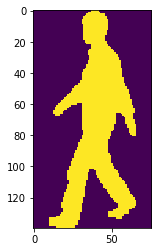

In [20]:
# add black
zeros = np.zeros([points[1]-points[0], 10])
cut_a = a[points[0]:points[1], points[2]:points[3]]
plt.imshow(np.concatenate([zeros,cut_a,zeros], axis=1))

In [172]:
path = './silhouettes'
new_path = './casia_b_cut'
subjects = os.listdir(path)
subjects = subjects[92:]

# this cell uses detect_silhouettes function to extract the persons from silhouettes, and save them, you could 
# change them based on your situation
for sub in subjects:
    for ii in range(1,7):
        sequence_path = os.path.join(path, sub, 'nm-0{}'.format(ii), '090')
        save_path = os.path.join(new_path, sub, 'nm-0{}'.format(ii))
        os.makedirs(save_path)
        seq_length = len(os.listdir(sequence_path))
    
         # 找最小的 find the smallest 
        min_n = 1000
        for each in os.listdir(sequence_path):      
            if int(each[14:17]) < min_n:
                min_n = int(each[14:17])
                
        for idx, nums in enumerate(range(min_n, min_n + seq_length - 1)):
            
            if len(str(nums)) == 2:
                img_path = os.path.join(sequence_path, '{}-nm-0{}-090-0{}.png'.format(sub, ii, nums))
            elif len(str(nums)) == 3:
                img_path = os.path.join(sequence_path, '{}-nm-0{}-090-{}.png'.format(sub, ii, nums))
            else:
                img_path = os.path.join(sequence_path, '{}-nm-0{}-090-00{}.png'.format(sub, ii, nums))
                
            img = imread(img_path)
            points = detect_silhouettes(img)
            
            # 微调 头顶中间 small variation 
            L_left = abs(points[2] - points[0][1])
            L_right = abs(points[3] - points[0][1])
            if L_left > L_right:
                if points[3] + (L_left - L_right) <= img.shape[1]:
                    points[3] = points[3] + (L_left - L_right)
            else:
                if points[2] - (L_right - L_left) >= 0:
                    points[2] = points[2] - (L_right - L_left)
                
            # add black
            if len(points) == 4:
                black = np.zeros([points[1]-points[0][0], 1])
                cut_img = img[points[0][0]:points[1], points[2]:points[3]]
            else:
                continue
                
            imsave(os.path.join(save_path, '{}-nm-0{}-{}.png'.format(sub, ii, idx+1)),
                   np.concatenate([black,cut_img,black], axis=1))        

FileNotFoundError: [Errno 2] No such file or directory: './silhouettes/068/nm-06/090'

In [173]:
# 高度一致 to reconcile the height of each extracted silhouettes
path = './casia_b_cut'
Sub = os.listdir(path)
for sub in Sub:
    for i in range(1,7):
        seq_path = os.path.join(path, sub, 'nm-0{}'.format(i))
        min_h = 100
        for img in os.listdir(seq_path)[:20]:
            img_path = os.path.join(seq_path, img)
            h = imread(img_path).shape[0]
            if h < min_h:
                min_h = h
        for x in os.listdir(seq_path):
            img_path = os.path.join(seq_path, x)
            width = imread(img_path).shape[1]
            new = imresize(imread(img_path), [min_h, width], interp='nearest')
            imsave(os.path.join(seq_path, x), new)

In [174]:
# 宽度一致 to reconcile the width of each extracted silhouettes
path = './casia_b_cut'
Sub = os.listdir(path)
for sub in Sub:
    for i in range(1,7):
        seq_path = os.path.join(path, sub, 'nm-0{}'.format(i))
        max_w = 0
        for img in os.listdir(seq_path)[:20]:
            img_path = os.path.join(seq_path, img)
            w = imread(img_path).shape[1]
            if w > max_w:
                max_w = w
#         if max_w/2 != 0:
#             max_w = max_w + 1
        for x in os.listdir(seq_path):
            img_path = os.path.join(seq_path, x)
            image = imread(img_path)
            shape = image.shape
            
            if max_w == shape[1]:
                continue
            else:
                gap = abs(shape[1] - max_w)
                    
                black = np.zeros([shape[0], gap//2])
                new = np.concatenate([black, image, black], axis=1)
    #             new = imresize(imread(img_path), [min_h, width], interp='nearest')
                imsave(os.path.join(seq_path, x), new)

In [175]:
# image size identify
path = './casia_b_cut'
Sub = os.listdir(path)
for sub in Sub:
    for i in range(1,7):
        seq_path = os.path.join(path, sub, 'nm-0{}'.format(i))
        
        for x in os.listdir(seq_path):
            img_path = os.path.join(seq_path, x)
            image = imread(img_path)

            new = imresize(image, [64, 64], interp='nearest')
            
            imsave(os.path.join(seq_path, x), new)

# Generate GEIs

In [5]:
def generate_GEI(image_list):
    '''
    Used to generate GEI
    '''
    N = len(image_list)
    GEI_image = 1/N*np.sum(image_list, axis=0)
    
    return GEI_image

def generate_GEI_for_casia(seq_path, start_frame, n_frames, sub_name, seq_name):
    '''
    generate GEI for Casia B
    '''
    images_list = np.ndarray((n_frames, 128, 88))
    
    
    
    for ii in range(1, n_frames+1):
        img_path = os.path.join(seq_path, '{}-nm-0{}-{}.png'.format(sub_name, seq_name, ii+start_frame))
        images_list[ii-1, :, :] = imresize(imread(img_path), [128,88], interp='nearest')
        
    return generate_GEI(images_list)

In [5]:
CSV = genfromtxt('./casia_b_cut/casia_b_GEI_list.csv',delimiter=',', dtype=np.int32)
CSV = CSV[1:]

In [195]:
start_frame = 0
n_frames = [1,2, 4,6,8,10,13,15,17] # different number of frames
# generate differnt incomplete GEIs composed of different number of frames
path = './casia_b_cut'
Sub = os.listdir(path)
for sub in Sub:
    save_sub_path = './casia_b_GEI/' + sub
    os.makedirs(save_sub_path)
    for i in range(1,7):
        save_seq_path = os.path.join(save_sub_path, 'nm-0{}'.format(i))
        os.makedirs(save_seq_path)
        seq_path = os.path.join(path, sub, 'nm-0{}'.format(i))
        for n_f in n_frames:
            
            GEI = generate_GEI_for_casia(seq_path,start_frame, n_f, sub, i)
                
            imsave(os.path.join(save_seq_path, '{}f-GEI.png'.format(str(n_f))), GEI)

NotADirectoryError: [Errno 20] Not a directory: './casia_b_cut/casia_b_GEI_list.csv/nm-01/casia_b_GEI_list.csv-nm-01-1.png'

025: 


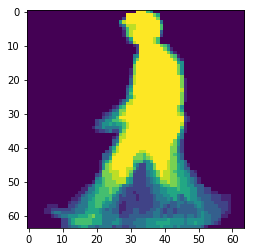

051: 


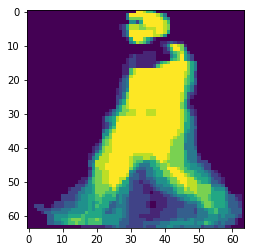

078: 


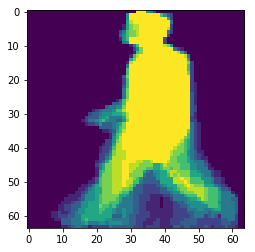

001: 


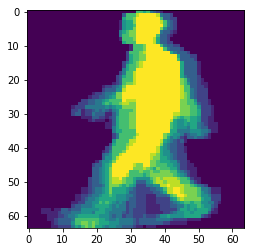

002: 


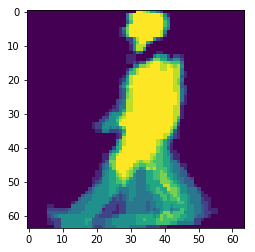

003: 


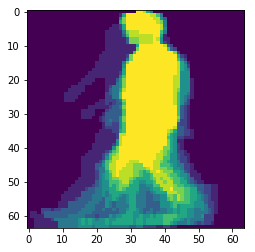

004: 


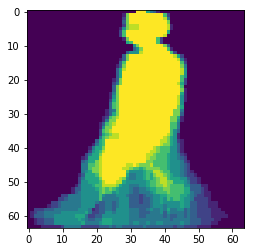

006: 


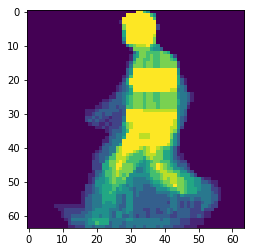

007: 


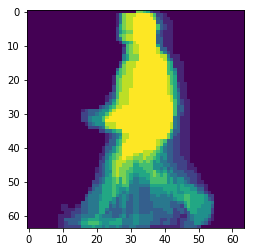

008: 


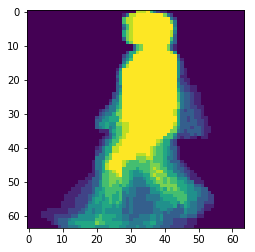

009: 


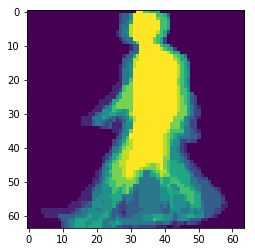

010: 


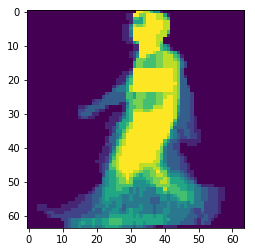

011: 


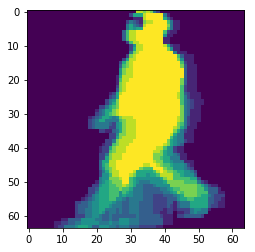

012: 


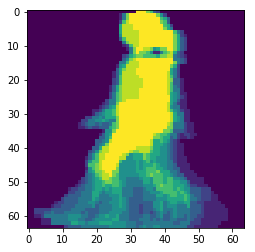

013: 


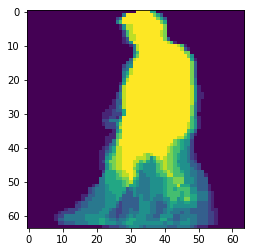

014: 


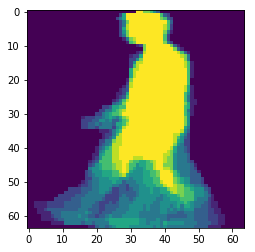

016: 


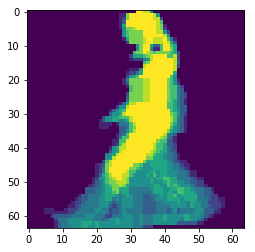

017: 


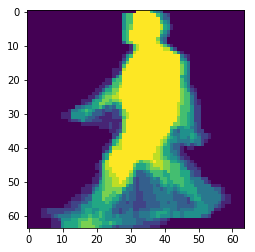

018: 


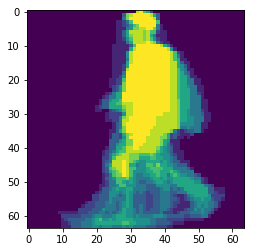

019: 


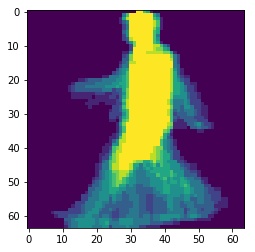

020: 


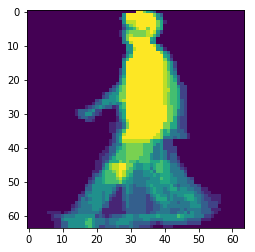

021: 


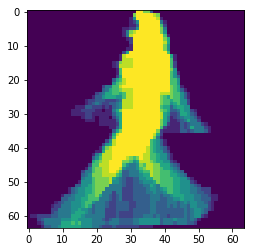

022: 


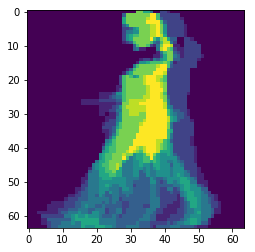

023: 


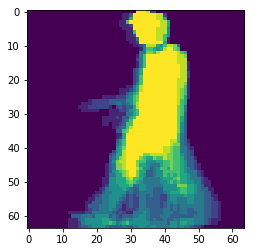

024: 


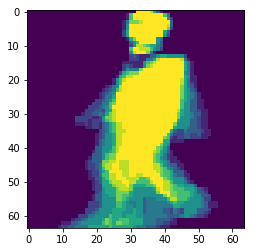

026: 


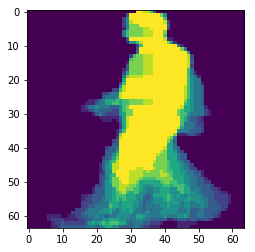

027: 


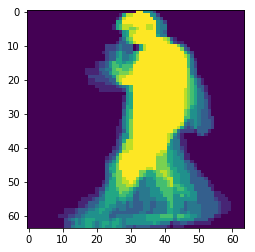

028: 


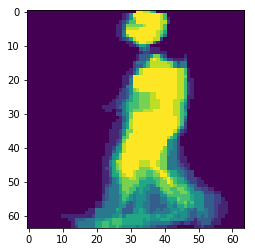

029: 


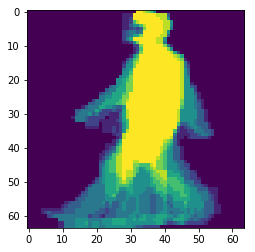

031: 


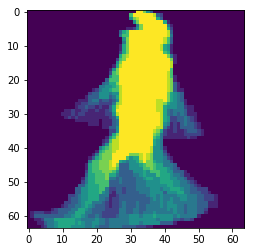

032: 


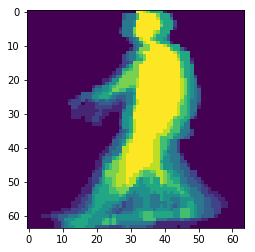

033: 


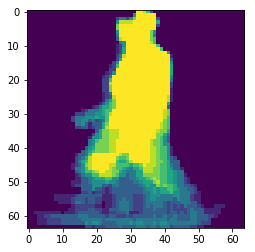

035: 


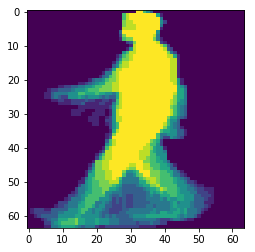

036: 


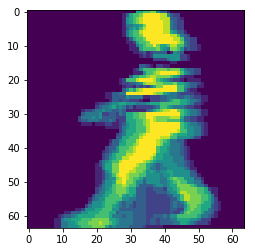

037: 


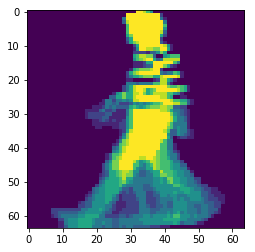

038: 


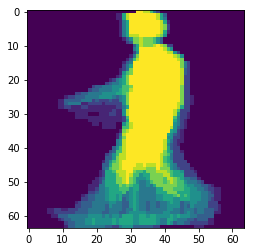

039: 


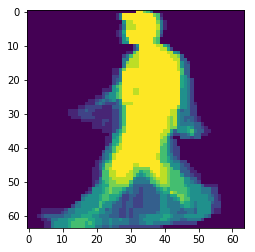

040: 


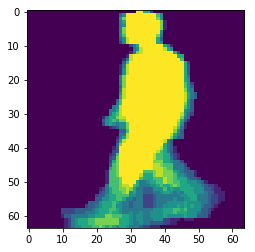

041: 


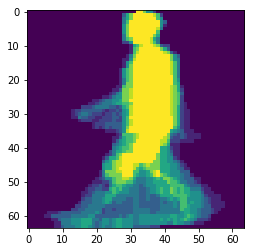

042: 


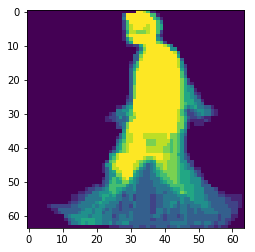

043: 


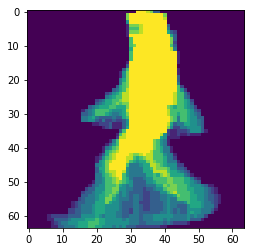

044: 


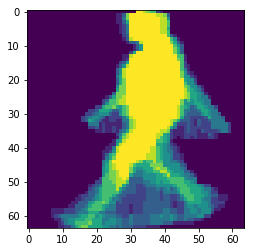

045: 


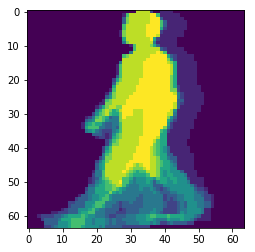

047: 


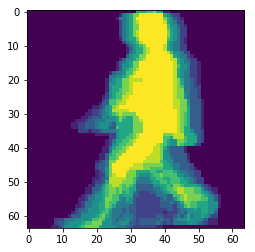

048: 


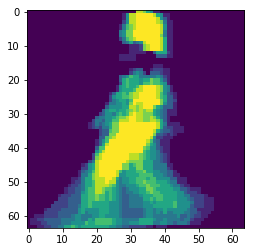

049: 


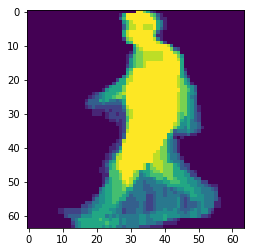

050: 


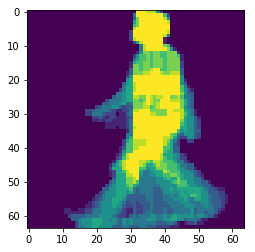

052: 


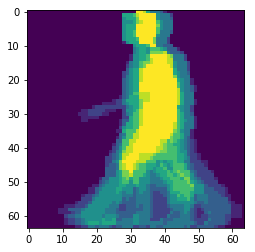

053: 


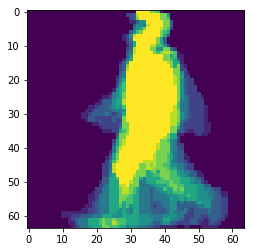

054: 


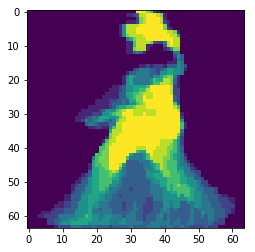

055: 


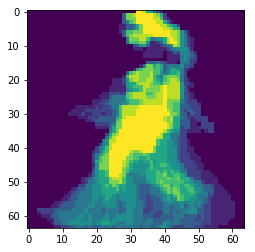

056: 


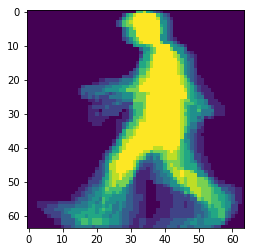

057: 


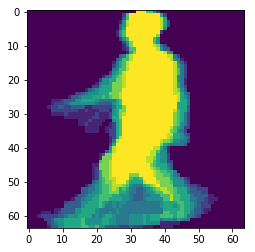

058: 


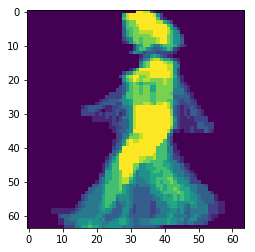

059: 


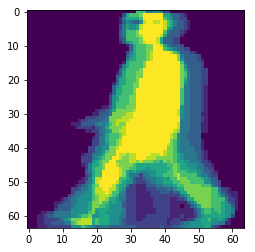

060: 


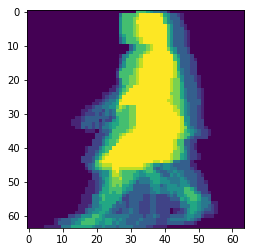

061: 


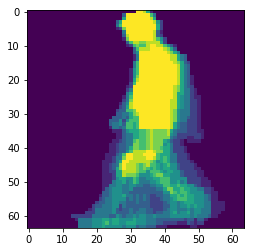

062: 


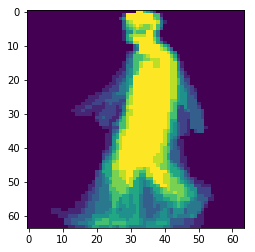

063: 


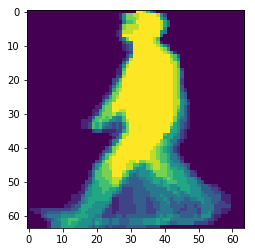

065: 


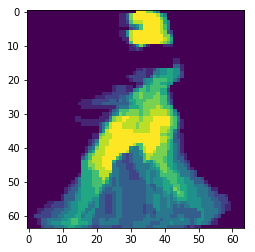

066: 


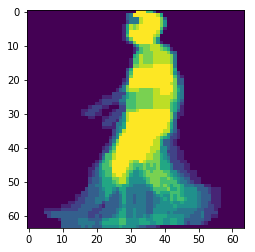

069: 


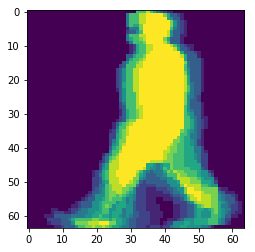

071: 


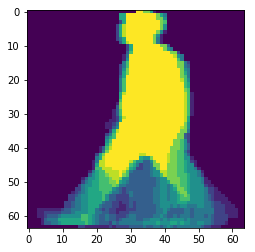

072: 


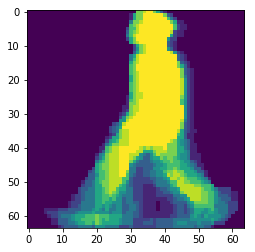

073: 


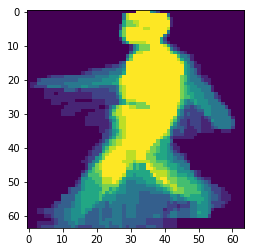

074: 


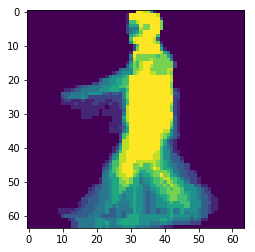

075: 


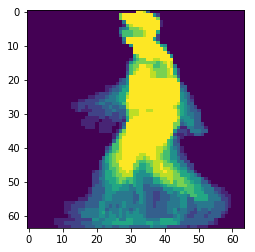

076: 


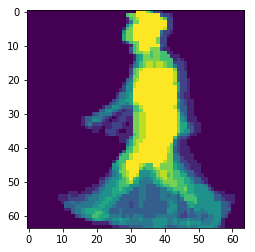

077: 


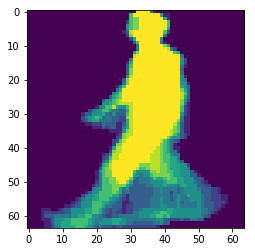

079: 


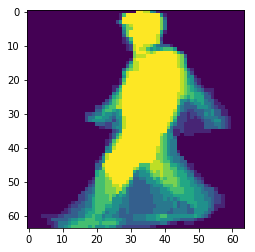

081: 


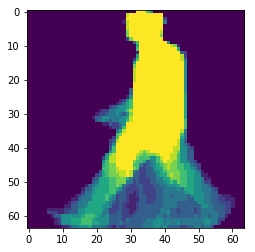

082: 


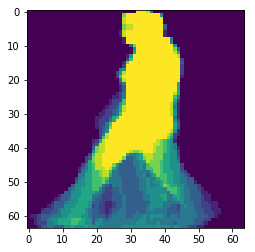

083: 


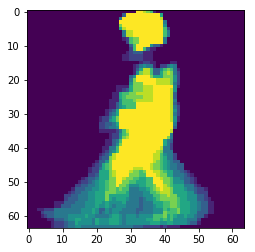

084: 


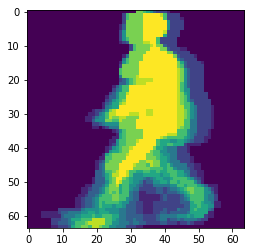

085: 


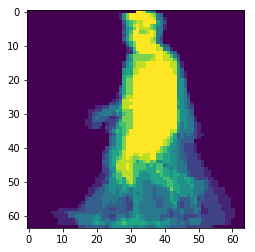

086: 


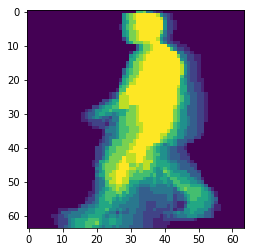

087: 


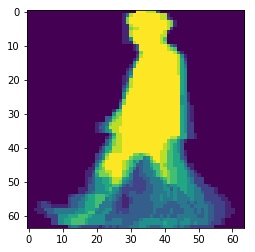

088: 


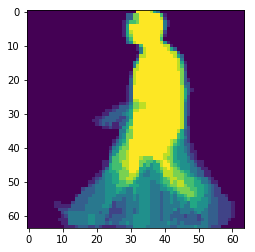

089: 


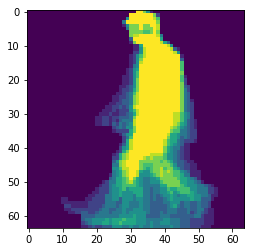

090: 


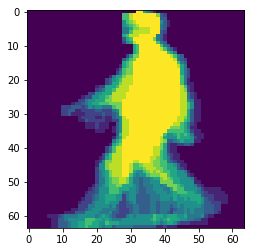

094: 


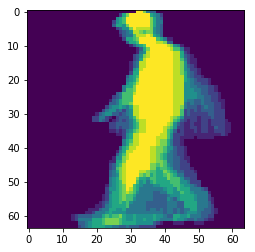

095: 


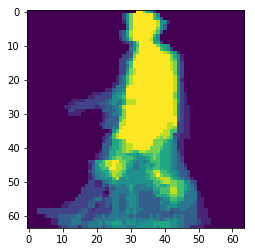

097: 


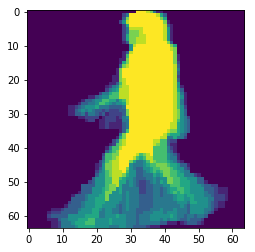

098: 


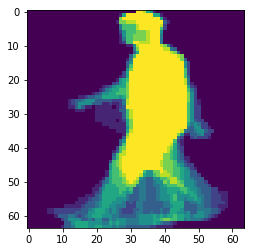

099: 


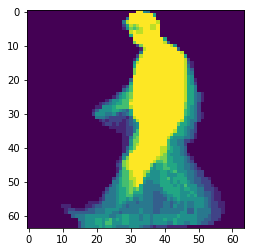

100: 


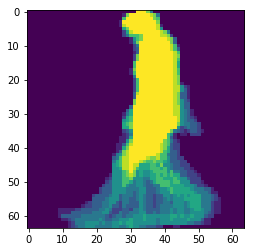

102: 


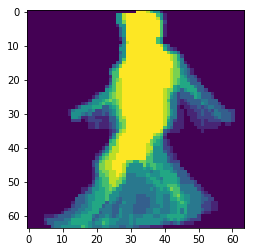

103: 


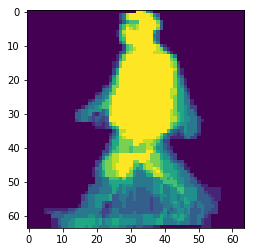

104: 


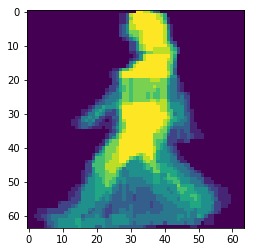

105: 


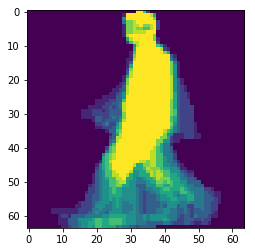

106: 


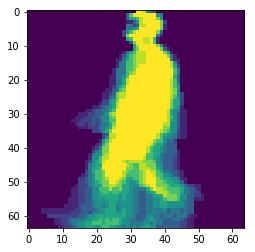

108: 


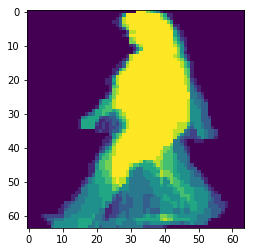

109: 


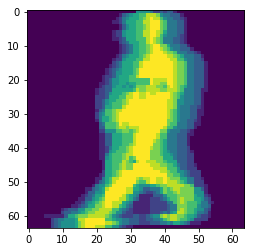

110: 


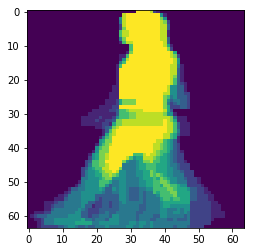

111: 


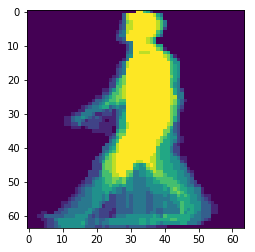

112: 


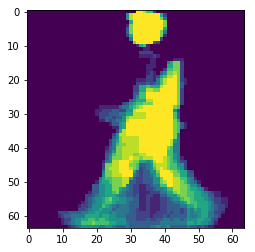

113: 


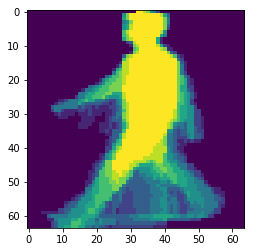

114: 


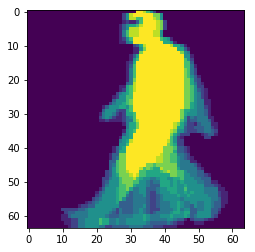

115: 


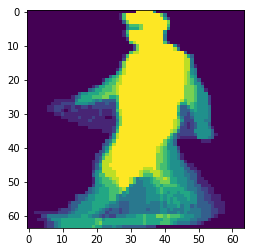

116: 


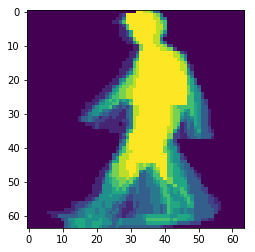

117: 


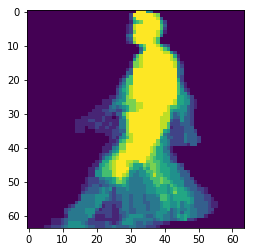

118: 


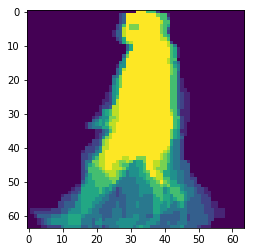

119: 


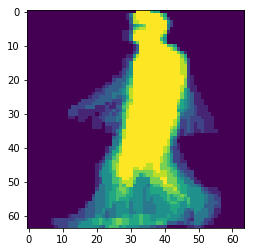

120: 


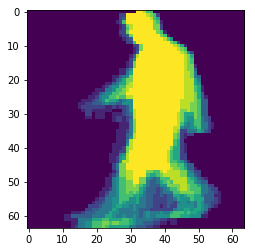

121: 


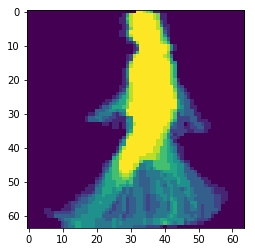

122: 


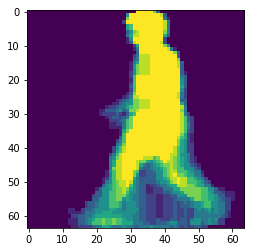

123: 


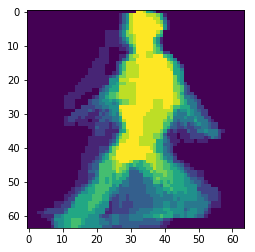

124: 


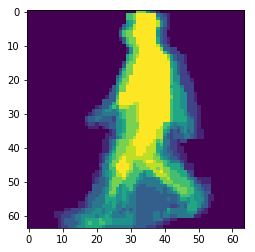

In [187]:
# 检测ＧＥI质量过差的ｓｕｂｊｅｃｔｓ
# detect the GEIs with extremely bad quality
path = './casia_b_GEI'
Sub = os.listdir(path)
for sub in Sub:

    seq_path = os.path.join(path, sub, 'nm-0{}'.format(i))
    print('{}: '.format(sub))
    plt.imshow(imread(os.path.join(seq_path, os.listdir(seq_path)[0])))
    plt.show()

In [197]:
# flip image 
n_frames = [1,2, 4,6,8,10,13,15,17]
# n_frames = [30]
path = './casia_b_GEI'
Sub = os.listdir(path)
for sub in Sub: 
    for i in range(1,7):
        save_seq_path = os.path.join(path, sub, 'nm-0{}'.format(i))
        for n_f in n_frames:
            
            img_path = os.path.join(save_seq_path, '{}f-GEI.png'.format(n_f))
            img = imread(img_path)
            imsave(img_path, cv2.flip(img,1))

FileNotFoundError: [Errno 2] No such file or directory: './casia_b_GEI/casia_b_GEI_list.csv/nm-01/1f-GEI.png'

In [3]:
for ii in range(1, 5):
    img_path = './samples/casiab/001-nm-01-{}.png'.format(ii)
    imsave(img_path, cv2.flip(imread('./samples/casiab/001-nm-01-{}.png'.format(ii)),1))

In [8]:
# image flip
# n_frames = [1,2, 4,6,8,10,13,15,17]
# n_frames = [30]
path = './gei'
Sub = os.listdir(path)
for sub in Sub: 
    for i in range(1,7):
        save_seq_path = os.path.join(path, sub, 'nm-0{}'.format(i))
        
        img_path = os.path.join(save_seq_path, '{}-nm-0{}-090.png'.format(sub, i))
        img = imread(img_path)
        imsave(img_path, cv2.flip(img,1))

NotADirectoryError: [Errno 20] Not a directory: './gei/ReadMe.txt/nm-01/ReadMe.txt-nm-01-090.png'

In [3]:
# create pathes
n_frames = [1,2,4,6,8,10,13,15,17]
path = './casia_b_GEI'
Sub = os.listdir(path)
print(len(Sub))

for n_f in n_frames:
    incom_GEI_path_list = []
    target_GEI_path_list = []
    for i in range(1,7):
        
        for sub in Sub:
            incom_GEI_path = os.path.join(path, sub, 'nm-0{}'.format(i), '{}f-GEI.png'.format(n_f))
    #             target_GEI_path = os.path.join(path, sub, 'nm-0{}'.format(i), '30f-GEI.png')
            target_GEI_path = os.path.join('./gei/{}'.format(sub), 'nm-0{}'.format(i), '{}-nm-0{}-090.png'.format(sub, i))
            incom_GEI_path_list.append(incom_GEI_path)
            target_GEI_path_list.append(target_GEI_path)

    with open('../gait_data/casia_b_GEI/GEI_{}f'.format(n_f), 'wb') as f:
        np.save(f, np.array(incom_GEI_path_list))
        
with open('../gait_data/casia_b_GEI/GEI_full_provide', 'wb') as f:
    np.save(f, np.array(target_GEI_path_list))

50


In [257]:
# add black 
n_frames = [1,3,5,8,10,13,15,18,20,30]

path = './casia_b_GEI'
Sub = os.listdir(path)
for sub in Sub: 
    for i in range(1,7):
        save_seq_path = os.path.join(path, sub, 'nm-0{}'.format(i))
        for n_f in n_frames:
            img_path = os.path.join(save_seq_path, '{}f-GEI.png'.format(n_f))
            img = imread(img_path)
            black = np.zeros([img.shape[0], 3])
            img = np.concatenate([black, img, black], axis=1)
            imsave(img_path, imresize(img, [128,88], interp='nearest'))

# Test with model

In [6]:
def get_batches(Subjects_path_X, Subjects_path_Y, batch_size):
    '''
    get batches during training
    '''
    n_batches = len(Subjects_path_X)//batch_size
    for ii in range(0, batch_size*n_batches, batch_size):
        data_batch = []
        target_batch = []
        for each_path_X, each_path_Y in zip(Subjects_path_X[ii:ii + batch_size], Subjects_path_Y[ii:ii + batch_size]):
            img_X = imread('{}'.format(each_path_X))
            img_Y = imread('{}'.format(each_path_Y))
            img_X = imresize(img_X, [64, 64], interp='nearest')
            img_Y = imresize(img_Y, [64, 64], interp='nearest')
            
            data_batch.append(img_X)
            target_batch.append(img_Y)
        data_batch = np.array(data_batch)/float(255)
        target_batch = np.array(target_batch)/float(255)
        
        data_batch = np.reshape(data_batch, [data_batch.shape[0], data_batch.shape[1], data_batch.shape[2], 1])
        target_batch = np.reshape(target_batch, [target_batch.shape[0], target_batch.shape[1], target_batch.shape[2], 1])
    
        yield data_batch, target_batch
        
def cal_accuracy(decoded, target):
    '''
    calculate accuracy during training 
    '''
    error = abs(decoded - target)
    Acc = (np.sum(error <= 0.08)/(decoded.shape[0]*decoded.shape[1]*decoded.shape[2]*decoded.shape[3]))*100
    
    return Acc

def save_decoded(decoded_batch, save_path, name_list):
    '''
    save decoded images
    '''
    reshape = np.reshape(decoded_batch, [decoded_batch.shape[0], decoded_batch.shape[1], decoded_batch.shape[2]])
    for ii, (image, name) in enumerate(zip(reshape, name_list)):
        imsave('{}/{}'.format(save_path, name), image)

In [7]:
For_test_x = np.load(open(r'../gait_data/casia_b_GEI/GEI64x64_For_test_x', mode='rb'))
For_test_y = np.load(open(r'../gait_data/casia_b_GEI/GEI64x64_For_test_y', mode='rb'))

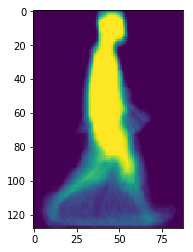

In [251]:
a = imread('./OULP-C1V2_Pack/OULP-GEI-(88x128)-full/Seq00/0000039/0000039_85_GEI_30f.png')
plt.imshow(a)

In [23]:
n_frames = ['1f', '2f', '4f', '6f', '8f', '10f', '13f', '15f', '17f']
# test with the test dat in caisia_b dataset using trained model, in order to save the resources, 
# the test data are saved as pathes, you can create your pathes follow the method that I create them, 
# it would be easier to understand.
for idx, n_f in enumerate(n_frames): 
    
    f_x = For_test_x[idx*60:idx*60 + 60]
    f_y = For_test_y[idx*60:idx*60 + 60]
    
    for ii in range(6):
  
        t_x = f_x[ii*10:ii*10 + 10]
        t_y = f_y[ii*10:ii*10 + 10]
        
        New_folder_path = './Casia_B_Pred/Casia_GEI-{}-complete_End-to-End/nm-0{}'.format(n_f, ii+1)
        os.makedirs(New_folder_path)

        test_batch_size = 10
        loaded_graph = tf.Graph()
        save_model_path = './checkpoints_view_invariant/choosed/All_full_Casia_6types_E2E_lr=6e-05_bs=80_nl=3_dim=128.ckpt'
        with tf.Session(graph=loaded_graph) as sess:
                    # Load model
            loader = tf.train.import_meta_graph(save_model_path + '.meta')
            loader.restore(sess, save_model_path)

                    # Get Tensors from loaded model
    #             test_inputs = loaded_graph.get_tensor_by_name('inputs_targets/inputs_1:0')
    #             test_targets = loaded_graph.get_tensor_by_name('inputs_targets/targets_1:0')
    #             test_training = loaded_graph.get_tensor_by_name('training:0')
    #             test_keep_p = loaded_graph.get_tensor_by_name('keep_prob:0')

    #             test_decoded = loaded_graph.get_tensor_by_name('output_layer/decoded:0')
    #             test_MSE= loaded_graph.get_tensor_by_name('MSE:0')
            test_inputs = loaded_graph.get_tensor_by_name('inputs:0')
            test_targets = loaded_graph.get_tensor_by_name('targets:0')
            test_training = loaded_graph.get_tensor_by_name('training:0')
            test_keep_p = loaded_graph.get_tensor_by_name('keep_prob:0')
            test_decoded = loaded_graph.get_tensor_by_name('output_layer/output:0')
            test_MSE = loaded_graph.get_tensor_by_name('MSE:0')

            test_mse = []
            test_acc = []
            mean_test_mse = 0
            mean_test_acc = 0

            for idx2, (test_batch, test_target_batch) in enumerate(get_batches(t_x, t_y, test_batch_size)):
            #                                          np.concatenate([val_x[3000+ii*500:3000+(ii+1)*500], test_x[3000+ii*500:3000+(ii+1)*500]], axis=0), 
            #                                          np.concatenate([val_y[3000+ii*500:3000+(ii+1)*500], test_y[3000+ii*500:3000+(ii+1)*500]], axis=0), test_batch_size)):


                feed_dict = {test_inputs: test_batch,
                                    test_targets: test_target_batch,
                                    test_training: 1,
                                    test_training:True
                                    }

                test_mean_squared_error, test_decoded_img = sess.run([test_MSE, test_decoded], feed_dict=feed_dict)
                
                name_list = []
                for name in t_x:
                    if idx <= 4:
                        name_list.append('{}-{}'.format(name[14:17], name[-10:]))
                    else:
                        name_list.append('{}-{}'.format(name[14:17],name[-11:]))
                
                save_decoded(test_decoded_img, New_folder_path, name_list)

                test_ACC = cal_accuracy(test_decoded_img, test_target_batch)

                test_mse.append(test_mean_squared_error)
                test_acc.append(test_ACC)

            mean_test_mse = np.mean(np.array(test_mse))
            mean_test_acc = np.mean(np.array(test_acc))

            print('mean_test_mse: {:.4f}'.format(mean_test_mse))
            print('mean_test_acc: {:.4f}'.format(mean_test_acc))

INFO:tensorflow:Restoring parameters from ./checkpoints_view_invariant/choosed/All_full_Casia_6types_E2E_lr=6e-05_bs=80_nl=3_dim=128.ckpt
mean_test_mse: 0.0032
mean_test_acc: 91.1914
INFO:tensorflow:Restoring parameters from ./checkpoints_view_invariant/choosed/All_full_Casia_6types_E2E_lr=6e-05_bs=80_nl=3_dim=128.ckpt
mean_test_mse: 0.0023
mean_test_acc: 92.3560
INFO:tensorflow:Restoring parameters from ./checkpoints_view_invariant/choosed/All_full_Casia_6types_E2E_lr=6e-05_bs=80_nl=3_dim=128.ckpt
mean_test_mse: 0.0028
mean_test_acc: 92.3706
INFO:tensorflow:Restoring parameters from ./checkpoints_view_invariant/choosed/All_full_Casia_6types_E2E_lr=6e-05_bs=80_nl=3_dim=128.ckpt
mean_test_mse: 0.0027
mean_test_acc: 92.1362
INFO:tensorflow:Restoring parameters from ./checkpoints_view_invariant/choosed/All_full_Casia_6types_E2E_lr=6e-05_bs=80_nl=3_dim=128.ckpt
mean_test_mse: 0.0024
mean_test_acc: 92.5537
INFO:tensorflow:Restoring parameters from ./checkpoints_view_invariant/choosed/All_fu

INFO:tensorflow:Restoring parameters from ./checkpoints_view_invariant/choosed/All_full_Casia_6types_E2E_lr=6e-05_bs=80_nl=3_dim=128.ckpt
mean_test_mse: 0.0015
mean_test_acc: 94.9561
INFO:tensorflow:Restoring parameters from ./checkpoints_view_invariant/choosed/All_full_Casia_6types_E2E_lr=6e-05_bs=80_nl=3_dim=128.ckpt
mean_test_mse: 0.0017
mean_test_acc: 93.8281
INFO:tensorflow:Restoring parameters from ./checkpoints_view_invariant/choosed/All_full_Casia_6types_E2E_lr=6e-05_bs=80_nl=3_dim=128.ckpt
mean_test_mse: 0.0018
mean_test_acc: 93.8013
INFO:tensorflow:Restoring parameters from ./checkpoints_view_invariant/choosed/All_full_Casia_6types_E2E_lr=6e-05_bs=80_nl=3_dim=128.ckpt
mean_test_mse: 0.0017
mean_test_acc: 94.7681
INFO:tensorflow:Restoring parameters from ./checkpoints_view_invariant/choosed/All_full_Casia_6types_E2E_lr=6e-05_bs=80_nl=3_dim=128.ckpt
mean_test_mse: 0.0017
mean_test_acc: 94.5215
INFO:tensorflow:Restoring parameters from ./checkpoints_view_invariant/choosed/All_fu

In [25]:
test_sub_list = ['111', '113', 
                 '115', '116', '117', '118', '119', '120', '121', '122']
# create path of predicted GEIs
n_frames = [1,2,4,6,8,10,13,15,17]
path = './Casia_B_Pred'
# n_frames = os.listdir(path)
#print(len(Sub))

for n_f in n_frames:
    Pred_GEI_path_list = []
    target_GEI_path_list = []
    for i in range(1,7):
        
        for sub in test_sub_list:
            Pred_GEI_path = os.path.join(path, 'Casia_GEI-{}f-complete_End-to-End'.format(n_f), 
                                         'nm-0{}'.format(i), '{}-{}f-GEI.png'.format(sub, n_f))
    #             target_GEI_path = os.path.join(path, sub, 'nm-0{}'.format(i), '30f-GEI.png')
            target_GEI_path = os.path.join('./gei/{}'.format(sub), 'nm-0{}'.format(i), '{}-nm-0{}-090.png'.format(sub, i))
            Pred_GEI_path_list.append(Pred_GEI_path)
            target_GEI_path_list.append(target_GEI_path)

    with open('../gait_data/casia_b_GEI/GEI_{}f_pred'.format(n_f), 'wb') as f:
        np.save(f, np.array(Pred_GEI_path_list))
        
with open('../gait_data/casia_b_GEI/GEI_test_pred', 'wb') as f:
    np.save(f, np.array(target_GEI_path_list))

In [26]:
from skimage.measure import compare_ssim as ssim
def mse(imageA, imageB):
	# the 'Mean Squared Error' between the two images is the
	# sum of the squared difference between the two images;
	# NOTE: the two images must have the same dimension
	err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
	err /= float(imageA.shape[0] * imageA.shape[1])
	
	# return the MSE, the lower the error, the more "similar"
	# the two images are
	return err

def cal_mean_accuracy(decoded, target):
    error = abs(decoded - target)
    Acc = (np.sum(error <= 0.08)/(decoded.shape[0]*decoded.shape[1]))*100
    
    return Acc

In [30]:
# The path of predicted GEIs
PredforTest_1f = np.load(open(r'../gait_data/casia_b_GEI/GEI_1f_pred', mode='rb'))
PredforTest_2f = np.load(open(r'../gait_data/casia_b_GEI/GEI_2f_pred', mode='rb'))
PredforTest_4f = np.load(open(r'../gait_data/casia_b_GEI/GEI_4f_pred', mode='rb'))
PredforTest_6f = np.load(open(r'../gait_data/casia_b_GEI/GEI_6f_pred', mode='rb'))
PredforTest_8f = np.load(open(r'../gait_data/casia_b_GEI/GEI_8f_pred', mode='rb'))
PredforTest_10f = np.load(open(r'../gait_data/casia_b_GEI/GEI_10f_pred', mode='rb'))
PredforTest_13f = np.load(open(r'../gait_data/casia_b_GEI/GEI_13f_pred', mode='rb'))
PredforTest_15f = np.load(open(r'../gait_data/casia_b_GEI/GEI_15f_pred', mode='rb'))
PredforTest_17f = np.load(open(r'../gait_data/casia_b_GEI/GEI_17f_pred', mode='rb'))
Pred_target = np.load(open(r'../gait_data/casia_b_GEI/GEI_test_pred', mode='rb'))

In [57]:
m  = []
s = []
acc = []
test_set = PredforTest_17f

for pred, target in zip(test_set, Pred_target):    
# test the quality of predicted GEIs

    Pred = imread(pred)
    target = imresize(imread(target), [64,64], interp='nearest')/255.0
            
    m.append(mse(Pred.astype(float), target.astype(float)))
    s.append(ssim(Pred.astype(float), target.astype(float)))
    acc.append(cal_mean_accuracy(Pred.astype(float), target.astype(float)))

In [58]:
print('mean mse {:.4f}'.format(np.mean(m)))
print('mse std {:.4f}'.format(np.std(np.array(m))))
print('             ')

print('mean ssim {:.4f}'.format(np.mean(s)))
print('std ssim {:.4f}'.format(np.std(np.array(s))))
print('             ')

print('mean Acc {:.4f}'.format(np.mean(acc)))
print('std Acc {:.4f}'.format(np.std(np.array(acc))))

mean mse 0.0017
mse std 0.0006
             
mean ssim 0.9543
std ssim 0.0173
             
mean Acc 94.4519
std Acc 2.0336


# Test with Recognition rate on verification tasks

In [59]:
def rescue_code(function):
    import inspect
    get_ipython().set_next_input("".join(inspect.getsourcelines(function)[0]))
    
def cal_FAR_FRR(targets, preds):
    '''
    client represents perfect match pairs
    impostor represents false match pairs
    '''
    count_false_rejection  = 0
    count_false_acceptance = 0
    count_client = 0
    count_impostor = 0
    for target,pred in zip(targets, preds):
        if int(target) == 1:
            count_client += 1
            if int(pred) == 0:
                count_false_rejection += 1 
                
        if int(target) == 0:
            count_impostor += 1
            if int(pred) == 1 and int(target) == 0:
                count_false_acceptance += 1
    
    FAR = count_false_acceptance/float(count_impostor) * 100
    FRR = count_false_rejection/float(count_client) * 100
    
    return FAR, FRR

def according_proba_get_pred(threshold, pred_proba):
    '''
    according probability to 
    '''
    predicted_results = []
    for prob_0, prob_1 in pred_proba:
        if prob_1 > threshold:
            predicted_results.append(1.0)
        else:
            predicted_results.append(0.0)
    return np.array(predicted_results)

def calculate_L2(gallery_list, probe_list):
    '''
    calculate L2 distance
    '''
#     label_0 = np.ndarray([len(gallery_list) * len(probe_list) - len(gallery_list), 1], dtype=float)
#     label_1 = np.ndarray([len(gallery_list), 1], dtype=float)
    L2_label_0 = []
    L2_label_1 = []
    label_1 = np.ones([len(gallery_list)], dtype=float)
    label_0 = np.zeros([len(gallery_list) * len(probe_list) - len(gallery_list)], dtype=float)

    for ii, gallery in enumerate(gallery_list):
        for jj, probe in enumerate(probe_list):
            
            L2_distance = np.sqrt(np.sum(np.square(gallery-probe)))
            
            if ii == jj:
                L2_label_1.append(L2_distance)
#                 total_label[jj + len(probe_list) * ii] = 1.0
            else:
                L2_label_0.append(L2_distance)
#                 total_label[jj + len(probe_list) * ii] = 0.0
    return np.reshape(np.array(L2_label_1), [len(L2_label_1), 1]), np.array(label_1), np.reshape(np.array(L2_label_0), [len(L2_label_0), 1]), np.array(label_0)

# Flatten
def flatten(x):
    '''
    flatten
    '''
    return np.reshape(x, [-1, x.shape[1] * x.shape[2]])

In [90]:
def generate_roc(L2, label):
    '''
    according L2 distances and labels to generate FAR and FRR, use them you can plot ROCs
    '''
    FAR_array = []
    FRR_array = []
    for threshold in np.arange(np.amin(L2, axis=0), np.amax(L2, axis=0), 0.03):
        predict = []
        for l2 in L2:
            if l2 <= threshold:
                predict.append(1.0)
            else:
                predict.append(0.0)
        FAR, FRR = cal_FAR_FRR(label, predict)
        FAR_array.append(FAR)
        FRR_array.append(FRR)
#         f1 = plt.figure(1) 
#         plt.xlabel('False acceptance rate [%]')
#         plt.ylabel('False rejection rate [%]')
#         plt.grid(linestyle=':')
#         plt.plot(FAR_array,FRR_array, label='Ground Truth') 
#         plt.legend(loc='lower right')
        
    return np.array(FAR_array), np.array(FRR_array)

### Find EER
def find_EER(FAR_array, FRR_array):
    '''
    according FAR and FRR to find EER
    FAR_array: FAR 
    FRR_array: FRR
    '''
    min_FAR = 1000
    min_FRR = 0
    for FAR, FRR in zip(FAR_array, FRR_array):
        if abs(FAR - FRR) < abs(min_FAR - min_FRR):
            min_FAR, min_FRR = FAR, FRR
    return (min_FAR + min_FRR)/2.0

def calculate_ROC_points(test_gallery, test_probe):
    '''
    This is the pipeline that could calculate the FAR and FRR of gallery and probe sets
    test_gallery: gallery set
    test_probe: probe set
    '''
    # flatten
    fla_gallery = flatten(test_gallery)
    fla_probe = flatten(test_probe)
    
    # zero mean
    gallery_mean_value = np.mean(np.concatenate([fla_gallery, fla_probe], axis=0))
    zeromean_gallery = fla_gallery - gallery_mean_value
    zeromean_probe = fla_probe - gallery_mean_value
    
    # pca
    pca = PCA(n_components=0.99)
    pca = pca.fit_transform(np.concatenate([zeromean_gallery, zeromean_probe], axis=0))
    
    # L2
    L2_1, label_1, L2_0, label_0 = calculate_L2(pca[:10], pca[10:])
    L2 = np.concatenate([L2_1,L2_0], axis=0)
    label = np.concatenate([label_1,label_0], axis=0)
    
    # shuffle
    L2, label = shuffle(L2, label)
    L2_3bit = np.around(L2, decimals=2)
    
    FAR, FRR = generate_roc(L2_3bit, label)
    
    return FAR, FRR

def read_test_data(gallery_path, probe_path, if_norm=False):
    '''
    gallery_path: The path of gallery
    probe_path: The path of probe
    if_norm: Some data are raw, need to be normalized and resized, for example test data have size 128x88.
             But the predicted GEIs are already normalized and have the size 64x64. 
    '''
    if if_norm:
        g_list = []
        p_list = []
        for g_path, p_path in zip(gallery_path, probe_path):
            g_list.append(imresize(imread(g_path), [64,64], interp='nearest')/255.0)
            p_list.append(imresize(imread(p_path), [64,64], interp='nearest')/255.0)
            
    if not if_norm:
        g_list = []
        p_list = []
        for g_path, p_path in zip(gallery_path, probe_path):
            g_list.append(imread(g_path))
            p_list.append(imread(p_path))
    
    return np.array(g_list), np.array(p_list)

In [112]:
# An example pipeline of test process, you can modify it based on your case
test_sub_list = ['111', '113', 
                 '115', '116', '117', '118', '119', '120', '121', '122']
gallery_seq =2
probe_seq =5
n_frames = 17
# generate gallery and probe sets
gallery_path = ['./Casia_B_Pred/Casia_GEI-{}f-complete_End-to-End/nm-0{}/{}-{}f-GEI.png'.format(n_frames,
                                                                    gallery_seq, sub, n_frames) for sub in test_sub_list]
probe_path = ['./Casia_B_Pred/Casia_GEI-{}f-complete_End-to-End/nm-0{}/{}-{}f-GEI.png'.format(n_frames, 
                                                                    probe_seq, sub, n_frames) for sub in test_sub_list]

g_list, p_list = read_test_data(gallery_path, probe_path, if_norm=False)
FAR_pred, FRR_pred = calculate_ROC_points(g_list, p_list)
# save path can be modified
with open('./Recognition rate/PCA_99%/Casia_FAR_Pred_{}f'.format(n_frames), 'wb') as f:
        np.save(f, np.array(FAR_pred))
with open('./Recognition rate/PCA_99%/Casia_FRR_Pred_{}f'.format(n_frames), 'wb') as f:
        np.save(f, np.array(FRR_pred))
print(find_EER(FAR_pred, FRR_pred))

7.77777777778


In [113]:
# The same pipeline as last cell, here test the EER of all possible combinations between gallery set and probe set,
# and print them out, as you can see different combinations have totally different results, that's why I show them 
# in my thesis in a way of minimal/maximal values (best/worst values). You can set the n_frames parameter to
# control the number of frames that consist of incomplete GEIs.
test_sub_list = ['111', '113', 
                 '115', '116', '117', '118', '119', '120', '121', '122']
for gallery_seq in [1, 2, 3, 4, 5, 6]:
    for probe_seq in [1, 2, 3, 4, 5, 6]:
        n_frames = 15
        gallery_path = ['./Casia_B_Pred/Casia_GEI-{}f-complete_End-to-End/nm-0{}/{}-{}f-GEI.png'.format(n_frames,
                                                                    gallery_seq, sub, n_frames) for sub in test_sub_list]
        probe_path = ['./Casia_B_Pred/Casia_GEI-{}f-complete_End-to-End/nm-0{}/{}-{}f-GEI.png'.format(n_frames, 
                                                                    probe_seq, sub, n_frames) for sub in test_sub_list]

        g_list, p_list = read_test_data(gallery_path, probe_path, if_norm=False)
        FAR_pred, FRR_pred = calculate_ROC_points(g_list, p_list)
        print(find_EER(FAR_pred, FRR_pred))
# EER_list.append(find_EER(FAR_pred, FRR_pred))
        

0.0
10.0
12.2222222222
2.22222222222
10.0
19.4444444444
10.0
0.0
10.0
8.88888888889
1.11111111111
10.0
12.2222222222
10.0
0.0
10.0
10.0
10.0
2.22222222222
8.88888888889
10.0
0.0
10.0
10.0
10.0
1.11111111111
10.0
10.0
0.0
10.0
19.4444444444
10.0
10.0
10.0
10.0
0.0


In [ ]:
# The same pipeline used to test the EERs of complete GEIs, namely the ground truth.
test_sub_list = ['111', '113', 
                 '115', '116', '117', '118', '119', '120', '121', '122']
for gallery_seq in [1, 2, 3, 4, 5, 6]:
    for probe_seq in [1, 2, 3, 4, 5, 6]:

        gallery_path = ['./gei/{}/nm-0{}/{}-nm-0{}-090.png'.format(sub, gallery_seq, sub,gallery_seq
                                                                    ) for sub in test_sub_list]
        probe_path = ['./gei/{}/nm-0{}/{}-nm-0{}-090.png'.format(sub, probe_seq, sub,probe_seq
                                                                 ) for sub in test_sub_list]

        g_list, p_list = read_test_data(gallery_path, probe_path, if_norm=False)
        FAR_pred, FRR_pred = calculate_ROC_points(g_list, p_list)
        print(find_EER(FAR_pred, FRR_pred))